In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch import nn



# Ignore warnings
#import warnings
#warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

Netværk

In [2]:
# with auto encoder:

import torch.nn.functional as F
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
           
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1728,2500)
        self.linear2 = nn.Linear(2500,1600)
        self.linear3 = nn.Linear(1600,1200)

        
        self.unflatten = nn.Unflatten(dim =1, unflattened_size = (12,10,10))
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 44, 3, padding=1)
        self.conv4 = nn.Conv2d(44, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv6 = nn.Conv2d(16, 12, 3, padding=1)
       
        self.pool = nn.MaxPool2d(2, 2)
        
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(12, 16, 3, stride=3, padding= 2)
        self.t_conv2 = nn.ConvTranspose2d(16, 32, 3, stride=2, padding = 2)
        self.t_conv3 = nn.ConvTranspose2d(32, 16 , 3, stride=1, padding = 1)
        self.t_conv4 = nn.ConvTranspose2d(16, 8, 2, stride=1)
        self.t_conv5 = nn.ConvTranspose2d(8, 3, 3, stride=1, padding = 1)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        return x
    # made flat layer deep to check if it would use more gpu.
    def flatlayer(self, x):
        x = self.flatten(x)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        return x
    
    def decode(self, x):
        x = self.unflatten(x)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = F.relu(self.t_conv5(x))
        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.flatlayer(x)
        x = self.decode(x)      
        return x


Læse trænet model ind

In [2]:
model = torch.load("Checkpoints/size_50_spohcs_300.pt")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


AttributeError: Can't get attribute 'ConvAutoencoder' on <module '__main__'>

Opdateret print_image funktion

In [31]:
def print_image(image, model):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.transpose(image.numpy(), (1, 2, 0)).astype('uint8'))
    image = torch.unsqueeze(image,0)
    image = torch.tensor(image).float()
    image = image.to(device)
    output = model(image)
    output = torch.squeeze(output,0)
    if device.type == 'cuda':
        output = torch.Tensor.cpu(output).detach().numpy()
    else:
        output = output.detach().numpy()
        

    ax2.imshow(np.transpose(output, (1, 2, 0)).astype('uint8'))
    plt.show()

Ny dataloader

In [32]:
transformer=transforms.Compose([
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                               transforms.Resize((50,50))
                           ])
#Create the data loader
class DataLoader_human(Dataset):
    def __init__(self, img_dir, transform = None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.fileNames = os.listdir(img_dir)
    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.fileNames[idx])
        #image = torchvision.io.ImageReadMode.RGB(img_path)
        image = read_image(img_path, mode = torchvision.io.image.ImageReadMode.RGB)
        
        image = torch.tensor(image).float()
        if self.transform:
            image = self.transform(image)
        return image

Læse data ind

C:\Users\malth\AppData\Local\Temp/ipykernel_19216/305078297.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).float()
C:\Users\malth\AppData\Local\Temp/ipykernel_19216/2770984871.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).float()


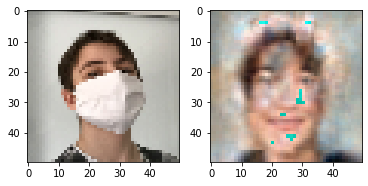

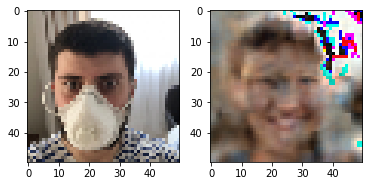

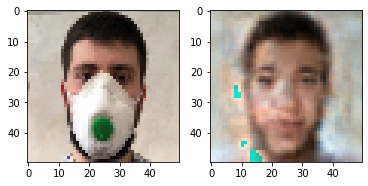

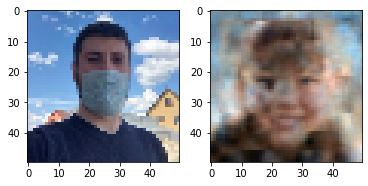

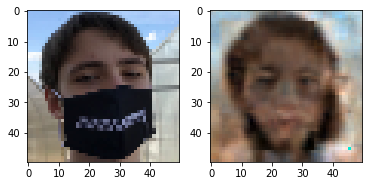

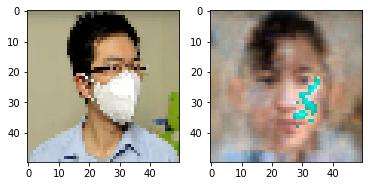

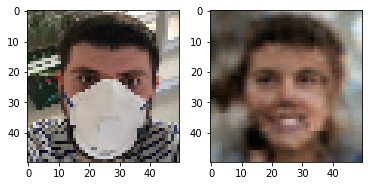

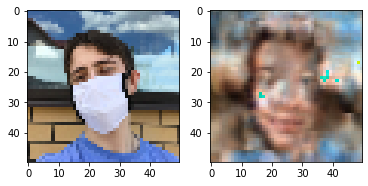

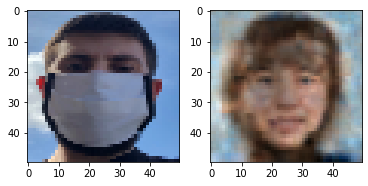

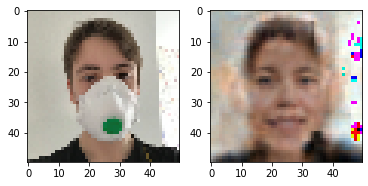

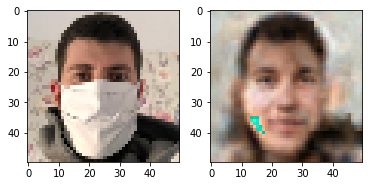

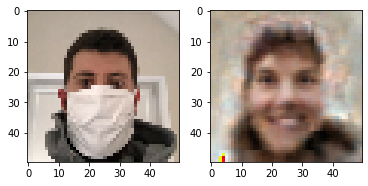

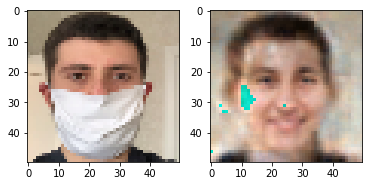

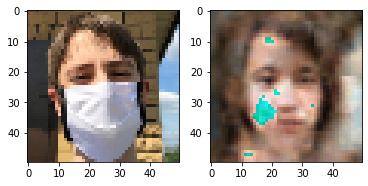

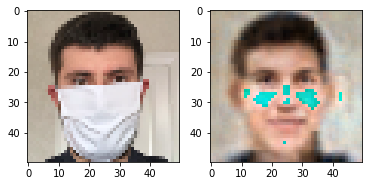

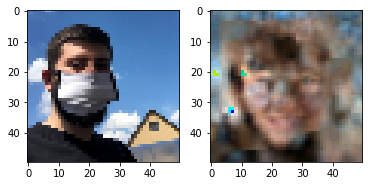

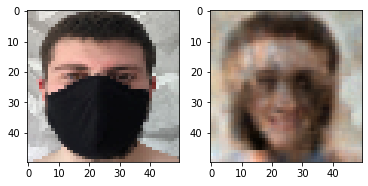

In [33]:
dataset = DataLoader_human("Data_real_human",transform = transformer) 
batch_size = 1
trainloader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0)

dataiter = iter(trainloader)

for i in range(17):
    images = dataiter.next()
    print_image(images[0], model = model)

In [ ]:
images = dataiter.next()
print(images)